In [29]:
import pandas as pd
import scipy as sc
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from operator import truediv, mul

# Data_cleaned

In [41]:
data_cleaned = pd.read_csv("data/data_cleaned.csv")
label = data_cleaned["Categorie1"].values
label_1=[]
label_2=[]
label_3=[]
label_4=[]
for k in label:
    if k=="TELEPHONIE - GPS":
        label_1+=[1]
        label_2+=[0]
        label_3+=[0]
        label_4+=[0]
    elif k=="INFORMATIQUE":
        label_1+=[0]
        label_2+=[1]
        label_3+=[0]
        label_4+=[0]
    elif k=="LIBRAIRIE":
        label_1+=[0]
        label_2+=[0]
        label_3+=[1]
        label_4+=[0]
    elif k=="VETEMENTS - LINGERIE " :
        label_1+=[0]
        label_2+=[0]
        label_3+=[0]
        label_4+=[1]
    else:
        label_1+=[0]
        label_2+=[0]
        label_3+=[0]
        label_4+=[0]
        
features = sc.sparse.load_npz("data/feature_sparse.npz")

In [42]:
print(label[0:100])

['INFORMATIQUE' 'TELEPHONIE - GPS' 'TELEPHONIE - GPS' 'TELEPHONIE - GPS'
 'TELEPHONIE - GPS' 'TELEPHONIE - GPS' 'BIJOUX -  LUNETTES - MONTRES'
 'ARTICLES POUR FUMEUR' 'SPORT (NEW)' 'AUTO - MOTO (NEW)'
 'AUTO - MOTO (NEW)' 'AUTO - MOTO (NEW)' 'TELEPHONIE - GPS'
 'AUTO - MOTO (NEW)' 'INFORMATIQUE' 'VETEMENTS - LINGERIE '
 'TELEPHONIE - GPS' 'JOUET (NEW)' 'LIBRAIRIE' 'INFORMATIQUE'
 'CULTURE / JEUX' 'INFORMATIQUE' 'VETEMENTS - LINGERIE '
 'TELEPHONIE - GPS' 'LOISIRS CREATIFS - BEAUX ARTS - PAPETERIE'
 'ANIMALERIE - NEW' 'BIJOUX -  LUNETTES - MONTRES' 'INFORMATIQUE'
 'DECO - LINGE - LUMINAIRE' 'BRICOLAGE - OUTILLAGE - QUINCAILLERIE'
 'DECO - LINGE - LUMINAIRE' 'DECO - LINGE - LUMINAIRE' 'LIBRAIRIE'
 'LIBRAIRIE' 'ARTICLES POUR FUMEUR' 'TELEPHONIE - GPS' 'TELEPHONIE - GPS'
 'BIJOUX -  LUNETTES - MONTRES' 'VETEMENTS - LINGERIE '
 'AUTO - MOTO (NEW)' 'ELECTRONIQUE' 'JARDIN - PISCINE' 'INFORMATIQUE'
 'VETEMENTS - LINGERIE ' 'DECO - LINGE - LUMINAIRE' 'LIBRAIRIE'
 'BRICOLAGE - OUTILLAGE - QUINCA

In [46]:
#X:descriptions, Y:categories
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.1, random_state=42)

In [47]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features, label_1, test_size=0.1, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features, label_2, test_size=0.1, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features, label_3, test_size=0.1, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(features, label_4, test_size=0.1, random_state=42)

### Apprentissage par classe:

In [48]:
lr_1= LogisticRegression()
lr_1.fit(X_train_1,y_train_1)
train_score_1 = lr_1.score(X_train_1,y_train_1)
print(train_score_1)

0.9934111111111111


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
lr_2= LogisticRegression()
lr_2.fit(X_train_2,y_train_2)
train_score_2 = lr_2.score(X_train_2,y_train_2)
print(train_score_2)

0.9930333333333333


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
lr_3= LogisticRegression()
lr_3.fit(X_train_3,y_train_3)
train_score_3 = lr_3.score(X_train_3,y_train_3)
print(train_score_3)

0.9973222222222222


In [51]:
lr_4= LogisticRegression()
lr_4.fit(X_train_4,y_train_4)
train_score_4 = lr_4.score(X_train_4,y_train_4)
print(train_score_4)

0.9959222222222223


### Apprentissage mutliclasse

In [8]:
ts = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
te = time.time()
print(te-ts, "sec")
train_score = lr.score(X_train,y_train) 
print(train_score) #Nombre de descriptions dont la prédiction est juste/Nombre de descriptions total

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


48.83159589767456 sec
0.9869777777777777


### Prediction

In [9]:
predict_1 = lr_1.predict(X_train_1)

In [10]:
predict_2 = lr_2.predict(X_train_2)

In [11]:
predict_3 = lr_3.predict(X_train_3)

In [52]:
predict_4 = lr_4.predict(X_train_4)

In [12]:
predict = lr.predict(X_train)

In [69]:
test_score = lr.score(X_test,y_test)
print("Score multi-class :",test_score, "\n")

print("Scores pour les regressions log binaires : \n")
test_score_1 = lr_1.score(X_test_1,y_test_1)
print("  Score TEL-GPS :",test_score_1, "\n")
test_score_2 = lr_2.score(X_test_2,y_test_2)
print("  Score INFO :",test_score_2, "\n")
test_score_3 = lr_3.score(X_test_3,y_test_3)
print("  Score LIB :",test_score_3, "\n")
test_score_4 = lr_4.score(X_test_4,y_test_4)
print("  Score VETEMENTS :",test_score_4, "\n")

Score multi-class : 0.9011 

Scores pour les regressions log binaires : 

  Score TEL-GPS : 0.9876 

  Score INFO : 0.9862 

  Score LIB : 0.9867 

  Score VETEMENTS : 0.9854 



In [70]:
def cross_cat(predictee,trainee):
    pred_cat = predictee==1
    train_cat = np.array(trainee)==1
    TP=0
    FN=0
    FP=0
    TN=0
    cross_tab = pd.crosstab(train_cat, pred_cat, rownames=["Ground True"], colnames=["Prediction"])
    #cross_tab = A.divide(A.sum(axis=1),axis=0)*100
    print(cross_tab)
    TP=cross_tab[1][1] #ok
    FN=cross_tab[0][1]
    FP=cross_tab[1][0]
    TN=cross_tab[0][0] #ok
    return len(trainee),TP,FN,FP,TN

In [71]:
nb_data_1,TP_1,FN_1,FP_1,TN_1=cross_cat(predict_1,y_train_1)
nb_data_2,TP_2,FN_2,FP_2,TN_2=cross_cat(predict_2,y_train_2)
nb_data_3,TP_3,FN_3,FP_3,TN_3=cross_cat(predict_3,y_train_3)
nb_data_4,TP_4,FN_4,FP_4,TN_4=cross_cat(predict_4,y_train_4)

cat= ["TELEPHONIE - GPS","INFORMATIQUE","LIBRAIRIE","VETEMENTS - LINGERIE "]
TP =[TP_1,TP_2,TP_3,TP_4]  #Vrai predit Vrai
TN = [TN_1,TN_2,TN_3,TN_4] #Faux predit faux


FP = [FP_1,FP_2,FP_3,FP_4] #Faux predit Vrai
FN = [FN_1,FN_2,FN_3,FN_4] #Vrai predit faux

Prediction   False  True 
Ground True              
False        70642    185
True           408  18765
Prediction   False  True 
Ground True              
False        76656    160
True           467  12717
Prediction   False  True 
Ground True              
False        78938    165
True            76  10821
Prediction   False  True 
Ground True              
False        84491    110
True           257   5142


In [72]:
#à comparer avec l'apprentissage sur toutes les classes !

for cat_name in cat :
    predict_cat = predict==cat_name
    y_train_cat = np.array(y_train)==cat_name
    cross_tab = pd.crosstab(y_train_cat, predict_cat, rownames=["Ground True"], colnames=["Prediction"])
    #cross_tab = A.divide(A.sum(axis=1),axis=0)*100
    print(cross_tab, '\n')
    TP += [cross_tab[1][1]]
    FP += [cross_tab[1][0]]
    TN += [cross_tab[0][0]]
    FN += [cross_tab[0][1]]

Prediction   False  True 
Ground True              
False        70627    200
True            94  19079 

Prediction   False  True 
Ground True              
False        76680    136
True           159  13025 

Prediction   False  True 
Ground True              
False        78629    474
True             0  10897 

Prediction   False  True 
Ground True              
False        84547     54
True            39   5360 



In [82]:
PFP=np.zeros(len(FP)) 
PFN=np.zeros(len(FN)) 
err=np.zeros(len(TP)) 
err2=np.zeros(len(TP)) 
for i in range(len(TP)) : 
    PFP[i] = FP[i]/(FP[i]+TN[i])*100
    PFN[i] = FN[i]/(FN[i]+TP[i])*100 
    err[i] = PFP[i]+PFN[i]
    err2[i] = (FN[i]+FP[i])/90000 * 100

    
cat = ["TELEPHONIE - GPS","INFORMATIQUE","LIBRAIRIE","VETEMENTS - LINGERIE ","GPS_mul","INFO_mul","LIB_mul","VET_mul"]

In [83]:
print(err)
print(err2)

[2.38919231 3.75046227 0.90602846 4.89016287 0.77265097 1.38305373
 0.59921874 0.78618502]
[0.65888889 0.69666667 0.26777778 0.40777778 0.32666667 0.32777778
 0.52666667 0.10333333]


In [84]:
def bar_plot_false(cat,PFN,PFP):
    fig = plt.figure(figsize=(10,10))
    plt.bar(cat,PFP,width = 0.5, color = 'blue', label="% faux positif")
    plt.bar(cat,PFN,width = 0.5, color = 'orange', label="% faux negatif")
    plt.title("Pourcentage de mauvaise prediction")
    plt.legend()
    fig.autofmt_xdate(rotation=45)

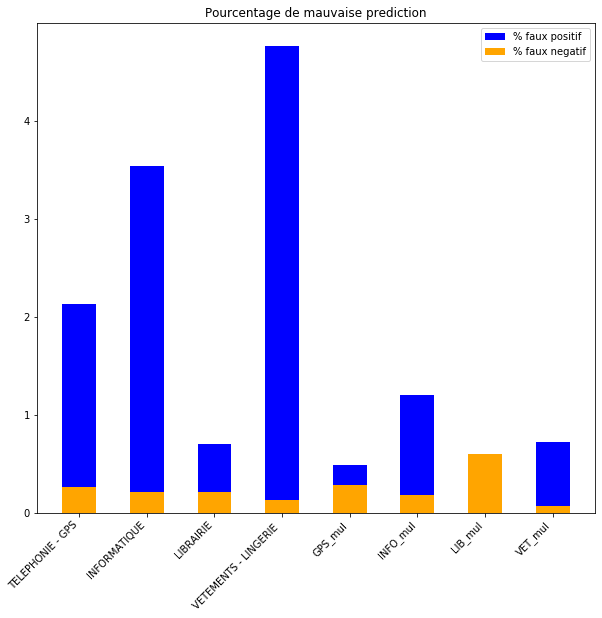

In [85]:
bar_plot_false(cat,PFP,PFN)

In [86]:
def bar_plot_error(cat,err):
    fig = plt.figure(figsize=(10,10))
    plt.bar(cat,err,width = 0.5, color = 'green', label="Error")
    plt.title("Erreur de prediction")
    plt.legend()
    fig.autofmt_xdate(rotation=45)

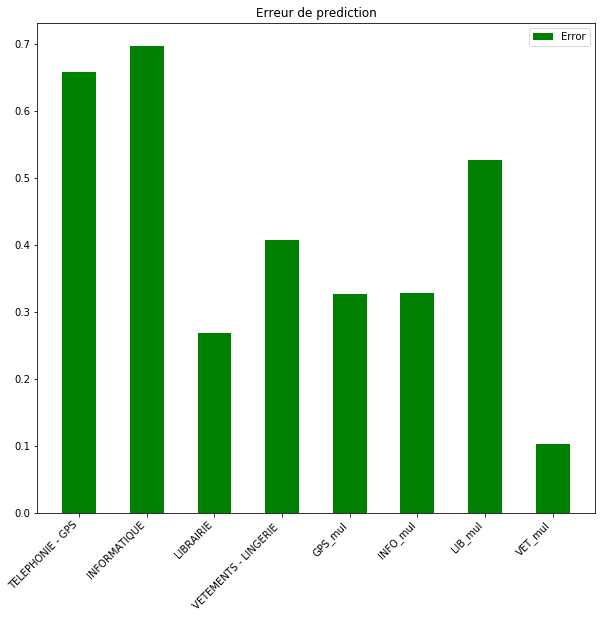

In [88]:
bar_plot_error(cat,err2)

### Comments : 

* Prediction meilleure en logistique multiclasse pour les catégorie Tel-GPS et Info par contre prediction meilleure pour librairie en logistique binaire.

* La raison ? Librairie a bcp moins de données dans la data set que Tel-GPS et Info ce qui pourrait expliquer que lorsqu'on a fait un apprentissage en logistique multiclasse l'erreur est plus importante que lorsque qu'on apprend en log binaire.


## Reduction X train

In [90]:
nb = [10000,50000,70000]
X_small_train = X_train[0:nb] #multi
y_small_train = y_train[0:nb]

X_small_train = X_train_1[0:nb] #GPS
y_small_train = y_train_1[0:nb]

TypeError: slice indices must be integers or None or have an __index__ method

In [12]:
lr_small = LogisticRegression()
lr_small.fit(X_small_train, y_small_train)
lr.score(X_small_train,y_small_train)

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.98684

In [13]:
Y_small_train_predict = lr_small.predict(X_small_train)
lr_small.score(X_test,y_test)

0.8833

In [14]:
print(train_score)
print(test_score) 

0.9869777777777777
0.9011


### Comments :

- Ok donc la prediction est moins bonne ce qui est logique car il y a moins de données d'apprentissage au préalable
- Peut etre essayer que sur les 3 plus grandes catégories voir ce que ça donne ?